# Simple classification with pytorch

## Data processing

### Create a csv file 

In [141]:
import glob
import yaml
import pandas as pd

def make_csv_path(excluded_labels=None):
    list_images = glob.glob('../data/raw/**/*.jpg', recursive=True)
    df = pd.DataFrame({'path': list_images})
    df['label'] = df['path'].apply(lambda x:os.path.basename(os.path.dirname(x)))
    if excluded_labels is not None:
        df = df[~df['label'].isin(excluded_labels)]
        print('Csv file constituted with {nrows} images, representing {nclasses} classes, excluding {exclusion}'.format(
        nrows=df.shape[0],
        nclasses=len(df['label'].unique()),
        exclusion= ','.join(excluded_labels)
        ))
    else:
        print('Csv file constituted with {nrows} images, representing the {nclasses} classes'.format(
            nrows=df.shape[0],
            nclasses=len(df['label'].unique())
        ))
    
    # Converting classes to number 
    labels = df['label'].unique()
    labels.sort()
    labels_map = {label:i for i, label in enumerate(labels)}
    df['y'] = df['label'].map(labels_map)

    labels_map_save = {i:label for i, label in enumerate(labels)}
    # Saving the map numbers -> label
    with open("../data/processed/labels_map.yaml", "w") as outfile:
        yaml.dump(labels_map_save, outfile)

    df.to_csv('../data/interim/filepath.csv', index=False)

make_csv_path(excluded_labels=['Corals', 'Crabs'])

Csv file constituted with 10704 images, representing 17 classes, excluding Corals,Crabs


### Creating a Custom Dataset class for the files 

In [154]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        filepath_df = pd.read_csv(annotations_file)
        self.img_labels = filepath_df['y']
        self.img_dir = filepath_df['path']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir[idx])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

dataset = CustomImageDataset(annotations_file='../data/interim/filepath.csv')

### Plot some images for verification

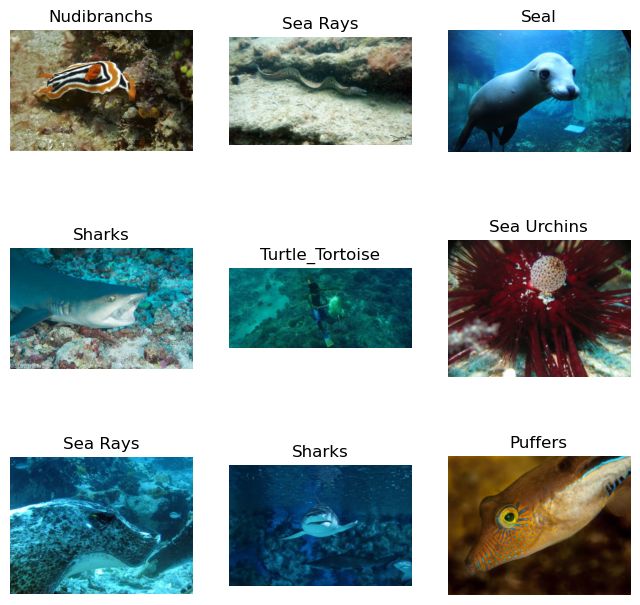

In [153]:
import matplotlib.pyplot as plt 
import torch

label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, y = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split the dataset + data augmentation

+ Split the datasets depending on parameters
    - Seed
    - Stratified
    - Training/test ratio
+ Track the files with dvc 
+ Data augmentation parameters for training data, test data ? 

## Training the network

+ Training depending on hyperparameters
    - learning rate
    - activation function ?
    - filters
    - dropout rate
+ Save the model
+ Monitoring 
    - parameters
    - training metrics (loss, time)


## Predict and evaluate on test set